In [1]:
%matplotlib inline
import importlib
from pytorch_utils_oh_2 import *

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
MODEL_SAVE_PATH = 'category_9_fixes'

In [4]:
import pytorch_utils_oh_2; importlib.reload(pytorch_utils_oh_2); from pytorch_utils_oh_2 import *;

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


# Data loading

In [5]:
all_data = pickle.load(open("data/en_train_fixed_5_manual.pkl", "rb" ))
sample_data = all_data[all_data['class'] != 'MANUAL']
del(all_data)

In [6]:
categories_all = sorted(sample_data["class"].unique())
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['ELECTRONIC', 'LETTERS', 'NOT_CHANGED', 'NUMBERS', 'PLAIN', 'VERBATIM']
6


### Utils stuff

In [7]:
chars_normal, chars_normal_index = load_characters_pkl('data/en_features/chars_normal.pkl')
print(''.join(chars_normal))

<SOS><EOS>☒ !"#$%&'(),-./0123456789:;ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyz~£¥ª²³µº¼½¾éɒʻˈΩμ—€⅓⅔⅛


In [8]:
common_words, common_words_index = load_common_words_10k()
len(common_words)
common_words[0:10]

8192

['<EOS>', '<SOS>', '<UNK>', '<0000>', '<SAMPLE>', '.', ',', 'the', '"', 'of']

### More balanced sample

In [9]:
balanced_data_classes_select = list(sample_data.groupby('class'))

balanced_data_accessed_counter = 0 
balanced_data_randomize_freq = False
balanced_data_length = 0

def balanced_data_randomize_org(max_len=20000):
    global balanced_data, balanced_data_length, balanced_data_accessed_counter, balanced_data_randomize_freq
    balanced_data = pd.concat([v.sample(min(max_len, len(v))) for k, v in balanced_data_classes_select])
    balanced_data_length = len(balanced_data)
    balanced_data_randomize_freq = balanced_data_length * 0.2
    balanced_data_accessed_counter = 0
balanced_data_randomize = balanced_data_randomize_org

def balanced_data_sample_row():
    global balanced_data_accessed_counter
    global balanced_data_last_sample
    balanced_data_accessed_counter += 1
    if balanced_data_randomize_freq and balanced_data_accessed_counter > balanced_data_randomize_freq:
        balanced_data_randomize()
    balanced_data_last_sample = balanced_data.iloc[random.randint(1, balanced_data_length-1)]
    return balanced_data_last_sample
    
balanced_data_randomize()

In [10]:
balanced_data.groupby("class")["class"].count()

class
ELECTRONIC      4964
LETTERS        20000
NOT_CHANGED    20000
NUMBERS        20000
PLAIN          20000
VERBATIM       11741
Name: class, dtype: int64

### Samples

In [11]:
def get_random_sample():
    sample_row = balanced_data_sample_row()   
    return sample_row['before'], sample_row['after'], sample_row['class'], sample_row['sentence'].split(' ')

def tmp():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    print(s_class, ':', s_bef, '->', s_aft)
    print(s_sentence)
    print(string_to_tensor(s_bef, chars_normal_index).shape)
    words_t = words_to_tensor(list(s_sentence), common_words_index)
    print(words_t.size())
    #return words_t[0]
    print([common_words[w[0]] for w in words_t[0].topk(1)[1]])
    
tmp = tmp()

LETTERS : TV -> t v
['news', 'is', 'people', ':', 'the', 'rise', 'of', 'local', '<SAMPLE>', 'news', 'and', 'the', 'fall', 'of', 'news', 'from', 'new', 'york', '.']
torch.Size([1, 3, 104])
torch.Size([1, 20, 8192])
['news', 'is', 'people', ':', 'the', 'rise', 'of', 'local', '<SAMPLE>', 'news', 'and', 'the', 'fall', 'of', 'news', 'from', 'new', 'york', '.', '<EOS>']


# Model

In [12]:
class CategorizeRNN(nn.Module):
    def __init__(self, output_size, words_input_size, chars_input_size, words_hidden_size, chars_hidden_size,
                 words_dropout=0, chars_dropout=0, words_layers=1, chars_layers=1):
        super(CategorizeRNN, self).__init__()
        
        self.words_layers = words_layers
        self.chars_layers = chars_layers
        self.words_hidden_size = words_hidden_size
        self.chars_hidden_size = chars_hidden_size

        self.rnn_words = nn.LSTM(words_input_size, words_hidden_size // 2, words_layers,
                                 dropout=words_dropout, batch_first=True, bidirectional=True)

        self.rnn_chars = nn.LSTM(chars_input_size, chars_hidden_size // 2, chars_layers,
                                 dropout=chars_dropout, batch_first=True, bidirectional=True)
        
        self.lin_output = nn.Linear(words_hidden_size+chars_hidden_size, output_size)
        
    def forward(self, words_tensor, string_tensor, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        all_outputs_words, hidden_words = self.rnn_words(words_tensor, hidden_words)
        output_words = all_outputs_words[:, -1]
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = all_outputs_chars[:, -1]
        
        output = torch.cat((output_words, output_chars), 1)
        
        output = self.lin_output(output)
        output = F.log_softmax(output)
        
        return output

    def init_hidden(self):
        var1_1 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var1_2 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var2_1 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        var2_2 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        var1_1 = var1_1.cuda(); var1_2 = var1_2.cuda()
        var2_1 = var2_1.cuda(); var2_2 = var2_2.cuda()
        return ((var1_1, var1_2), (var2_1, var2_2))

In [13]:
model = CategorizeRNN(len(categories_all), 
                      words_input_size=len(common_words), chars_input_size=len(chars_normal),
                      words_hidden_size=256, chars_hidden_size=384,
                      words_layers=2, chars_layers=2,
                      words_dropout=0.2, chars_dropout=0.2)
model = model.cuda()

model_training = ModelTraining(MODEL_SAVE_PATH, [model])

model

Save path: data/models/category_9_fixes


CategorizeRNN (
  (rnn_words): LSTM(8192, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (rnn_chars): LSTM(104, 192, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (lin_output): Linear (640 -> 6)
)

### Accuracy

In [25]:
def test_model_single_sample(model):
    s_bef, s_aft, s_class, s_sentence = sample = get_random_sample()
    
    words_t = words_to_tensor(s_sentence, common_words_index)
    words_t = Variable(words_t).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    output = model(words_t, string_t)
    guess = category_from_output(output, categories_all)

    return output, guess, (s_class, categories_index[s_class]), sample
    
tmp = test_model_single_sample(model)
tmp

(Variable containing:
 -1.8007 -1.7389 -1.8102 -1.8169 -1.8332 -1.7542
 [torch.cuda.FloatTensor of size 1x6 (GPU 0)],
 ('LETTERS', 1),
 ('PLAIN', 4),
 ('jr', 'junior', 'PLAIN', ['"', 'richard', 'blood', '<SAMPLE>', '"', '.']))

In [26]:
def print_local_wrong_predictions(max_results=10):
    arr = get_some_wrong_predictions(model, test_model_single_sample, max_iterations=10000, max_results=max_results)
    for sample, predict, output in arr:
        s_bef, s_aft, s_class, s_sentence = sample
        m = torch.nn.functional.softmax(output).max().data[0]
        print("{:>11} -> {:>11} ({:0.3}) || {:>8} -> {} == {}".format(s_class, predict[0], m, s_bef, s_aft, ' '.join(s_sentence), ))

In [27]:
print_local_wrong_predictions(max_results=1)

NOT_CHANGED ->     LETTERS (0.176) ||        , -> , == " distinguiran al presidente de soka gakkai de japon " <SAMPLE> el deber .


### Training

In [28]:
def train(model, s_category, s_sentence, s_bef, loss_function, optimizer):
    
    category_tensor = Variable(torch.LongTensor([categories_index[s_category]])).cuda()
    
    words_t = words_to_tensor(s_sentence, common_words_index)
    words_t = Variable(words_t).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    output = model(words_t, string_t)
    loss = loss_function(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.data[0]

In [29]:
def train_iterations(n_iters=100000, lr=0.001, print_every=10000, plot_every=1000):

    start = time.time()
    model.train()

    current_loss = 0
    current_loss_iter = 0

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        model_training.iterations += 1
        
        s_bef, s_aft, s_class, s_sentence = get_random_sample()
        
        result, loss = train(model=model, s_category=s_class, s_sentence=s_sentence,
                             s_bef=s_bef, optimizer=optimizer, loss_function=loss_function)

        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            guess, guess_i = category_from_output(result, categories_all)
            correct = '✓' if guess == s_class else "✗ {}".format(s_class)
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} ({})".format(
                      model_training.iterations, iteration/n_iters, time_since(start),
                      current_loss/current_loss_iter, loss,
                      s_bef, guess, correct))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model_training.losses.append(current_loss / plot_every)
            model_training.learning_rates.append(lr)
            current_loss = 0
            current_loss_iter = 0
            
        if model_training.iterations % 50000 == 0 or model_training.iterations == 10:
            model_training.save_models()
            acc = test_model_accuracy(model, test_model_single_sample)
            model_training.accuracy.append(acc)
    
    # test_model_accuracy(model, n_sample=10000)

In [30]:
train_iterations(n_iters=50, print_every=9, lr=0.0001)

     9  18% (   0m 0s)   1.805   |   1.81: " -> LETTERS (✗ NOT_CHANGED)
Saved model to data/models/category_9_fixes/10_(CategorizeRNN)
Accuracy: 20.40% (    2040/   10000)
    18  36% (  0m 28s)   1.805   |   1.80: March 18, 2015 -> LETTERS (✗ NUMBERS)
    27  54% (  0m 28s)   1.795   |   1.77: & -> LETTERS (✗ VERBATIM)
    36  72% (  0m 28s)   1.794   |   1.81: - -> LETTERS (✗ PLAIN)
    45  90% (  0m 28s)   1.791   |   1.88: http://www.carwashmag.com/issues/sept-2011/marketing.cfmCar -> LETTERS (✗ ELECTRONIC)


In [31]:
train_iterations(n_iters=(1000-model_training.iterations), print_every=500, lr=0.0001)

   550  53% (   0m 5s)   1.679   |   2.98: Jobberman.com -> NUMBERS (✗ ELECTRONIC)


In [32]:
train_iterations(n_iters=10000, lr=0.0001, print_every=1000)

  2000  10% (  0m 10s)   1.080   |   0.40: Générale -> NOT_CHANGED (✓)
  3000  20% (  0m 21s)   0.785   |   0.05: 20 May 1990 -> NUMBERS (✓)
  4000  30% (  0m 32s)   0.620   |   0.41: the -> NOT_CHANGED (✓)
  5000  40% (  0m 42s)   0.492   |   0.10: glamourgirlsofthesilverscreen.com -> ELECTRONIC (✓)
  6000  50% (  0m 54s)   0.456   |   0.18: US -> LETTERS (✓)
  7000  60% (   1m 5s)   0.460   |   0.03: June 15, 1969 -> NUMBERS (✓)
  8000  70% (  1m 17s)   0.423   |   1.00: " -> PLAIN (✗ NOT_CHANGED)
  9000  80% (  1m 29s)   0.324   |   0.32: Smt -> LETTERS (✓)
 10000  90% (  1m 39s)   0.372   |   0.49: LR21.com.uy -> ELECTRONIC (✓)
 11000 100% (  1m 50s)   0.307   |   0.05: KK -> LETTERS (✓)


In [33]:
train_iterations(n_iters=89000, print_every=10000)

 21000  11% (  1m 44s)   0.259   |   0.00: & -> VERBATIM (✓)
 31000  22% (  3m 25s)   0.116   |   0.00: # -> VERBATIM (✓)
 41000  34% (   5m 5s)   0.157   |   0.03: wider -> NOT_CHANGED (✓)
Saved model to data/models/category_9_fixes/50000_(CategorizeRNN)
Accuracy: 96.69% (    9669/   10000)
 51000  45% (  7m 12s)   0.113   |   0.02: Organisation -> PLAIN (✓)
 61000  56% (  8m 52s)   0.089   |   0.00: & -> VERBATIM (✓)
 71000  67% ( 10m 32s)   0.076   |   0.00: programme -> PLAIN (✓)
 81000  79% ( 12m 12s)   0.087   |   0.00: Centre -> PLAIN (✓)
 91000  90% ( 13m 52s)   0.088   |   0.00: programme -> PLAIN (✓)
Saved model to data/models/category_9_fixes/100000_(CategorizeRNN)
Accuracy: 97.92% (    9792/   10000)


In [34]:
print_local_wrong_predictions()

      PLAIN ->     LETTERS (0.424) ||     Bros -> brothers == " english bread and yeast cookery " , penguin : middlesex 1977 ( p . 139 ) " sugar : a handbook for planters and refiners " , lock & newlands <SAMPLE> , pub .
 ELECTRONIC ->     NUMBERS (1.0) || 2009-11-25Visitmexico.com -> t w o o o n i n e d a s h e l e v e n d a s h t w e n t y f i v e v i s i t m e x i c o dot c o m == retrieved <SAMPLE> , retrieved 2009 - 11 - 25lakedistrict . gov . uk , retrieved 2009 - 11 - 25winecountry . com , retrieved 2009 - 11 - 25 farmer , cjq ; fotheringham , as ( 2011 ) .
      PLAIN ->     LETTERS (0.491) ||     Bros -> brothers == warner <SAMPLE> eventually bought schlesinger 's cartoon unit in 1944 and renamed it warner bros cartoons .
    LETTERS -> NOT_CHANGED (0.612) ||    Hemsl -> h e m s l == " author query for ' <SAMPLE> . '
NOT_CHANGED ->     LETTERS (0.962) ||    UNDER -> UNDER == he has also represented pakistan under 19s , averaging 37 . 20 in <SAMPLE> 19 test matches , and 45 . 4

In [35]:
train_iterations(n_iters=100000, lr=0.0005, print_every=10000)

110000  10% (  1m 39s)   0.061   |   0.00: 6 March 1945 -> NUMBERS (✓)
120000  20% (  3m 19s)   0.069   |   0.01: PG -> LETTERS (✓)
130000  30% (  4m 59s)   0.058   |   0.00: vol -> PLAIN (✓)
140000  40% (  6m 39s)   0.047   |   0.00: born -> NOT_CHANGED (✓)
150000  50% (  8m 19s)   0.051   |   0.00: USNews.com -> ELECTRONIC (✓)
Saved model to data/models/category_9_fixes/150000_(CategorizeRNN)
Accuracy: 98.65% (    9865/   10000)
160000  60% ( 10m 26s)   0.073   |   0.00: 2011 -> NUMBERS (✓)
170000  70% (  12m 5s)   0.049   |   0.00: 1997 -> NUMBERS (✓)
180000  80% ( 13m 45s)   0.047   |   0.00: & -> VERBATIM (✓)
190000  90% ( 15m 26s)   0.057   |   0.00: & -> VERBATIM (✓)
200000 100% (  17m 7s)   0.056   |   0.00: AFC -> LETTERS (✓)
Saved model to data/models/category_9_fixes/200000_(CategorizeRNN)
Accuracy: 98.48% (    9848/   10000)


In [36]:
print_local_wrong_predictions()

NOT_CHANGED ->     LETTERS (0.749) ||      Act -> Act == congress responded with the naval <SAMPLE> of 1794 .
    LETTERS -> NOT_CHANGED (0.652) ||      Yby -> y b y == once there , take the exit to <SAMPLE> yau city .
      PLAIN ->    VERBATIM (0.999) ||        ~ -> to == " genetic dissection of the mir 17 <SAMPLE> 92 cluster of micrornas in myc induced b - cell lymphomas " .
    LETTERS -> NOT_CHANGED (0.406) ||     Misr -> m i s r == " bint <SAMPLE> " means " egyptian girl " in arabic .
    NUMBERS ->     LETTERS (0.805) ||       V. -> five == mark <SAMPLE> wetherington ( 1 september 2001 ) .
    NUMBERS -> NOT_CHANGED (0.43) ||        X -> ten == " final fantasy <SAMPLE> scenario writer on the possibility of final fantasy x - 3 " .
NOT_CHANGED ->       PLAIN (0.997) ||        - -> - == december 2006 , p . 12 <SAMPLE> 13 .
NOT_CHANGED ->       PLAIN (0.964) ||        : -> : == beijing <SAMPLE> renmin weisheng chubanshe .
NOT_CHANGED ->       PLAIN (0.92) ||    three -> three == he 

In [37]:
train_iterations(n_iters=100000, lr=0.001, print_every=10000)

210000  10% (  1m 40s)   0.072   |   0.00: & -> VERBATIM (✓)
220000  20% (  3m 22s)   0.086   |   0.00: have -> NOT_CHANGED (✓)
230000  30% (   5m 2s)   0.051   |   0.00: & -> VERBATIM (✓)
240000  40% (  6m 43s)   0.078   |   0.00: 10 -> NUMBERS (✓)
250000  50% (  8m 24s)   0.054   |   0.00: st -> PLAIN (✓)
Saved model to data/models/category_9_fixes/250000_(CategorizeRNN)
Accuracy: 98.32% (    9832/   10000)
260000  60% ( 10m 31s)   0.041   |   0.00: - -> PLAIN (✓)
270000  70% ( 12m 11s)   0.030   |   0.00: ISBN -> LETTERS (✓)
280000  80% ( 13m 50s)   0.037   |   0.00: III -> NUMBERS (✓)
290000  90% ( 15m 31s)   0.053   |   0.04: MK -> LETTERS (✓)
300000 100% ( 17m 11s)   0.039   |   0.00: - -> PLAIN (✓)
Saved model to data/models/category_9_fixes/300000_(CategorizeRNN)
Accuracy: 98.55% (    9855/   10000)


In [38]:
print_local_wrong_predictions()

    LETTERS -> NOT_CHANGED (0.816) ||     Omul -> o m u l == « <SAMPLE> de otel » impotriva garzii de fier " ( " armand calinescu : a sacrifice for the country 's peace and security .
NOT_CHANGED ->     LETTERS (0.48) ||     Paul -> Paul == <SAMPLE> menard was the polesitter .
    LETTERS -> NOT_CHANGED (0.974) ||      Vit -> v i t == 25 ; porphyry , <SAMPLE> .
    NUMBERS ->     LETTERS (1.0) ||       I. -> one == vol <SAMPLE> london : richard bentley .
NOT_CHANGED ->     LETTERS (0.896) ||      Las -> Las == this was to provide a direct interstate link between the <SAMPLE> vegas and phoenix metropolitan areas .
NOT_CHANGED ->     LETTERS (0.875) ||       us -> us == your kings should expect nothing from <SAMPLE> except humiliation .
NOT_CHANGED ->     LETTERS (0.684) ||     Navy -> Navy == all of this , including the striking of her name from the <SAMPLE> list , occurred on 15 august 1973 .
    LETTERS -> NOT_CHANGED (0.648) ||     caos -> c a o s == author of the prose story frammen

In [39]:
train_iterations(n_iters=200000, lr=0.0005, print_every=10000)

310000   5% (  1m 39s)   0.055   |   0.00: 1887 -> NUMBERS (✓)
320000  10% (  3m 19s)   0.043   |   0.00: with -> NOT_CHANGED (✓)
330000  15% (  4m 59s)   0.043   |   0.00: x -> PLAIN (✓)
340000  20% (  6m 40s)   0.041   |   0.00: December 7, 2008 -> NUMBERS (✓)
350000  25% (  8m 20s)   0.054   |   0.00: Facebookwww.bachatamovie.com -> ELECTRONIC (✓)
Saved model to data/models/category_9_fixes/350000_(CategorizeRNN)
Accuracy: 98.85% (    9885/   10000)
360000  30% ( 10m 27s)   0.066   |   0.00: during -> NOT_CHANGED (✓)
370000  35% (  12m 7s)   0.035   |   0.00: unveiled -> NOT_CHANGED (✓)
380000  40% ( 13m 46s)   0.055   |   0.00: Theatre -> PLAIN (✓)
390000  45% ( 15m 27s)   0.042   |   0.00: Deadline.com -> ELECTRONIC (✓)
400000  50% (  17m 7s)   0.028   |   0.02: eki -> LETTERS (✓)
Saved model to data/models/category_9_fixes/400000_(CategorizeRNN)
Accuracy: 99.15% (    9915/   10000)
410000  55% ( 19m 13s)   0.040   |   0.00: 12 -> NUMBERS (✓)
420000  60% ( 20m 54s)   0.041   |   0

In [40]:
print_local_wrong_predictions()

NOT_CHANGED ->     LETTERS (0.95) ||     camp -> camp == it was named by sgt neil felver of the 122 civil engineering squadron in a name the <SAMPLE> contest .
      PLAIN -> NOT_CHANGED (0.956) || specialising -> specializing == from 1979 to 1986 he studied economics at the vienna university of economics and business administration , <SAMPLE> in environmental economics .
    LETTERS -> NOT_CHANGED (0.534) ||   aaseae -> a a s e a e == field investigation of allium <SAMPLE> ( aase 's onion ) on the boise national forest .
NOT_CHANGED ->     LETTERS (0.997) ||      MAC -> MAC == also , central michigan received 18 votes to win the <SAMPLE> championship game .
      PLAIN ->     LETTERS (0.449) ||      Vol -> volume == american anthropologist , <SAMPLE> 76 , pp 890 , oct . 1974 turner , terence 1992 .
 ELECTRONIC ->     LETTERS (0.968) ||      www -> w w w == eight specific internet terms may not be registered ( ftp , localhost , whois , <SAMPLE> , no , nic , internet and internett ) .
N

In [41]:
train_iterations(n_iters=200000, lr=0.0001, print_every=25000)

525000  12% (  4m 11s)   0.040   |   0.00: etc -> PLAIN (✓)
550000  25% (  8m 23s)   0.025   |   0.00: bxn -> LETTERS (✓)
Saved model to data/models/category_9_fixes/550000_(CategorizeRNN)
Accuracy: 99.13% (    9913/   10000)
575000  38% (  13m 0s)   0.042   |   0.00: 879 -> NUMBERS (✓)
600000  50% ( 17m 11s)   0.015   |   0.00: & -> VERBATIM (✓)
Saved model to data/models/category_9_fixes/600000_(CategorizeRNN)
Accuracy: 99.30% (    9930/   10000)
625000  62% ( 21m 46s)   0.019   |   0.00: - -> PLAIN (✓)
650000  75% ( 25m 57s)   0.022   |   0.00: January 27, 2003 -> NUMBERS (✓)
Saved model to data/models/category_9_fixes/650000_(CategorizeRNN)
Accuracy: 99.15% (    9915/   10000)
675000  88% ( 30m 35s)   0.044   |   0.00: associated -> NOT_CHANGED (✓)
700000 100% ( 34m 46s)   0.034   |   0.00: # -> VERBATIM (✓)
Saved model to data/models/category_9_fixes/700000_(CategorizeRNN)
Accuracy: 99.17% (    9917/   10000)


In [42]:
print_local_wrong_predictions()

      PLAIN ->     LETTERS (0.703) ||       OO -> oxygen monoxide == " <SAMPLE> reference desk : real names list " .
    LETTERS ->       PLAIN (0.981) ||       ST -> s t == lokomotywa spalinowa serii <SAMPLE> 48 , " ś wiat kolei " nr .
NOT_CHANGED ->       PLAIN (0.62) ||    arise -> arise == as rex brings the torchwood team to america , problems <SAMPLE> on the plane .
NOT_CHANGED ->       PLAIN (0.819) ||        : -> : == " timeline <SAMPLE> crisis at wrexham fc " .
NOT_CHANGED ->     LETTERS (1.0) ||      byl -> byl == " to <SAMPLE> ostatni mecz bieniuka " .
    LETTERS -> NOT_CHANGED (0.996) ||    Cibao -> c i b a o == juan played winter ball for gigantes del <SAMPLE> of the dominican winter baseball league .
NOT_CHANGED ->     LETTERS (0.922) ||  LAURELS -> LAURELS == " lutz , grayson only coast stars on a . p . all american : four southern aces given <SAMPLE> " .
    LETTERS -> NOT_CHANGED (0.44) ||    ReOCl -> r e o c l == the oxychlorides are most common , and include <SAMPLE>

In [46]:
time.sleep(40*60*60)

In [47]:
train_iterations(n_iters=300000, lr=0.0001, print_every=10000)

710000   3% (  2m 26s)   0.025   |   0.00: -382 -> NUMBERS (✓)
720000   7% (  4m 39s)   0.067   |   0.00: mission -> NOT_CHANGED (✓)
730000  10% (  6m 25s)   0.025   |   0.00: USA- -> LETTERS (✓)
740000  13% (   8m 5s)   0.022   |   0.33: Zod -> LETTERS (✓)
750000  17% (  9m 49s)   0.043   |   0.00: 5ms -> NUMBERS (✓)
Saved model to data/models/category_9_fixes/750000_(CategorizeRNN)
Accuracy: 99.31% (    9931/   10000)
760000  20% ( 11m 57s)   0.036   |   0.00: www.rock -> ELECTRONIC (✓)
770000  23% ( 13m 37s)   0.035   |   0.00: 2015 -> NUMBERS (✓)
780000  27% ( 15m 19s)   0.015   |   0.00: 26 July -> NUMBERS (✓)
790000  30% ( 16m 58s)   0.024   |   0.00: specialises -> PLAIN (✓)
800000  33% ( 18m 39s)   0.024   |   0.00: J. -> LETTERS (✓)
Saved model to data/models/category_9_fixes/800000_(CategorizeRNN)
Accuracy: 99.21% (    9921/   10000)
810000  37% ( 20m 46s)   0.023   |   0.00: pp -> LETTERS (✓)
820000  40% ( 22m 26s)   0.040   |   0.00: HTTPS -> LETTERS (✓)
830000  43% (  24m 

In [48]:
print_local_wrong_predictions()

NOT_CHANGED ->    VERBATIM (0.547) ||        m -> m == <SAMPLE> wape miti ( born 24 may 1973 ) is a former zambian football ( soccer ) striker .
    LETTERS -> NOT_CHANGED (1.0) ||     igen -> i g e n == in 1998 , she released a book on theatre history , om <SAMPLE> , herr molander !
    LETTERS ->       PLAIN (0.997) ||      bvl -> b v l == aspen boasts ralph lauren , dior , louis vuitton , prada , gucci , fendi , <SAMPLE> gari , burberry , brioni , theory and ermenegildo zegna boutiques .
NOT_CHANGED ->     LETTERS (0.946) ||      SET -> SET == " indian hero' s burial <SAMPLE> for wednesday " .
NOT_CHANGED ->       PLAIN (0.959) ||        : -> : == new dehli <SAMPLE> anmol publications , 1997 .
    LETTERS ->     NUMBERS (0.964) ||    III's -> i i i's == son frankie christian followed a year later in los angeles on november 16 , 1975 , a day before marvin <SAMPLE> birthday .
NOT_CHANGED ->     LETTERS (0.997) ||     BAND -> BAND == often wears a band shirt that reads " <SAMPLE> " .
N

In [49]:
train_iterations(n_iters=300000, lr=0.00005, print_every=10000)

1010000   3% (  1m 40s)   0.021   |   0.00: Current -> NOT_CHANGED (✓)
1020000   7% (  3m 20s)   0.022   |   0.00: the -> NOT_CHANGED (✓)
1030000  10% (   5m 1s)   0.030   |   0.00: , -> NOT_CHANGED (✓)
1040000  13% (  6m 42s)   0.038   |   0.00: 200 -> NUMBERS (✓)
1050000  17% (  8m 22s)   0.039   |   0.00: medterms.comOverview -> ELECTRONIC (✓)
Saved model to data/models/category_9_fixes/1050000_(CategorizeRNN)
Accuracy: 99.27% (    9927/   10000)
1060000  20% ( 10m 29s)   0.055   |   0.00: & -> VERBATIM (✓)
1070000  23% ( 12m 10s)   0.061   |   0.00: M. L. -> LETTERS (✓)
1080000  27% ( 13m 50s)   0.020   |   0.00: Organised -> PLAIN (✓)
1090000  30% ( 15m 30s)   0.043   |   0.00: Indiana -> NOT_CHANGED (✓)
1100000  33% ( 17m 11s)   0.014   |   0.00: PS -> LETTERS (✓)
Saved model to data/models/category_9_fixes/1100000_(CategorizeRNN)
Accuracy: 99.35% (    9935/   10000)
1110000  37% ( 19m 19s)   0.036   |   0.00: C. -> LETTERS (✓)
1120000  40% ( 20m 59s)   0.025   |   0.00: - -> PLA

In [50]:
print_local_wrong_predictions()

    LETTERS -> NOT_CHANGED (0.81) ||      Cey -> c e y == morgan lester <SAMPLE> ( born october 27 , 1981 ) is a canadian former professional ice hockey goaltender .
NOT_CHANGED ->     LETTERS (1.0) ||       IF -> IF == he was an honorary member of both nesodden <SAMPLE> and kolbotn il .
NOT_CHANGED ->     LETTERS (0.996) ||    TURBO -> TURBO == " xbox 3 60 live arcade : super street fighter ii <SAMPLE> — hd remix " .
NOT_CHANGED ->     LETTERS (0.699) ||     Pion -> Pion == " cassetta telegrafica cample , officine pio — <SAMPLE> " .
NOT_CHANGED ->     LETTERS (0.829) ||       Un -> Un == <SAMPLE> algorithme optimal pour la ligne de partage des eaux .
NOT_CHANGED ->     LETTERS (0.753) ||      Lac -> Lac == fond du <SAMPLE> .
NOT_CHANGED ->     LETTERS (0.999) || SASKATCHEWAN -> SASKATCHEWAN == " encyclopedia of <SAMPLE> ( list of forts in northern saskatchewan ) " .
    LETTERS -> NOT_CHANGED (0.714) ||      Rac -> r a c == adaptor protein xb 130 is a <SAMPLE> controlled component of 

# Results

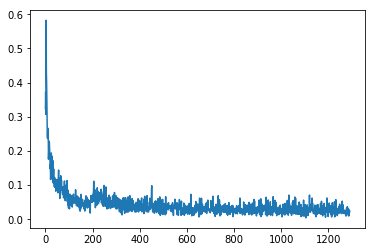

In [51]:
plt.figure()
plt.plot(model_training.losses[7:])

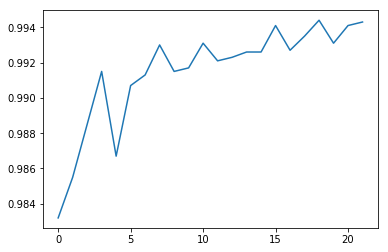

In [52]:
plt.figure()
plt.plot(model_training.accuracy[5:])

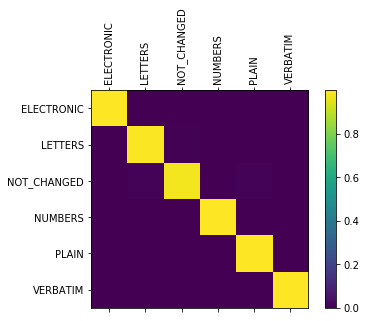

Accuracy: 99.35% (   49675/   50000)
CPU times: user 9min 39s, sys: 3.74 s, total: 9min 42s
Wall time: 2min 26s


In [53]:
%%time
plot_category_confusion_matrix(model, categories_all, test_model_single_sample, n_confusion=50000)

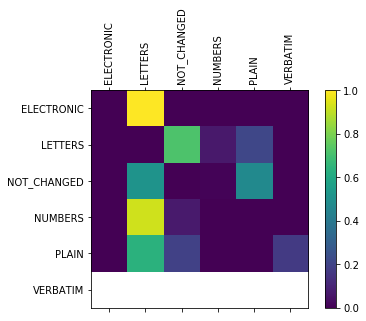

Accuracy: 99.30% (   49651/   50000)
CPU times: user 10min 5s, sys: 4.08 s, total: 10min 9s
Wall time: 2min 33s


In [54]:
%%time
plot_category_confusion_matrix(model, categories_all, test_model_single_sample,
                               n_confusion=50000, remove_diagonal=True)